In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from scipy import integrate
from tqdm import tqdm

In [2]:
w = 2.6617e-6
G = 6.67e-11
mT = 5.9736e24
rT = 6.3781e6
mL = 0.07349e24
rL = 1.7374e6
d = 3.844e8

dTL = rT + rL + d

In [3]:
def System(v,t):
    
    r,phi,pr,pphi = v

    delta = G*mT/d**3

    rp = np.sqrt(1+r**2-2*r*np.cos(phi-w*t))

    mu = mL/mT
    
    rdot = pr
    phidot = pphi/(r**2)
    prdot = pphi**2/(r**3) - delta*(1/r**2+mu/(rp**3)*(r-np.cos(phi-w*t)))
    pphidot = -delta*mu*(r*np.sin(phi-w*t))/(rp**3)
    
    return np.array([rdot,phidot,prdot,pphidot])

In [4]:
dt = 1.
tmax = 6.5e5
t = np.arange(0,tmax,dt)

In [5]:
v0 = 11.1e3
theta = 45.*(np.pi/180)
phi0 = 45.*(np.pi/180)

In [6]:
V0 = np.array([v0*np.cos(theta), v0*np.sin(theta)])
pr0 = (v0/d)*np.cos(theta-phi0)
pphi0 = (rT/d)*(v0/d)*np.sin(theta-phi0)
r0 = np.array([rT/d, phi0, pr0, pphi0]) #radio0, phi0, pr0, pphi0

Con paso adaptativo:

In [7]:
def Increment(f, v, t, h):
    
    state1 = np.array([v[0], v[1], v[2], v[3]])
    k1 = f(state1, t)


    state2 = np.array([v[0]+0.5*h*k1[0], v[1]+0.5*h*k1[1], v[2]+0.5*h*k1[2], v[3]+0.5*h*k1[3]])
    k2 = f(state2, t+0.5*h)

    state3 = np.array([v[0]+0.5*h*k2[0], v[1]+0.5*k2[1], v[2]+0.5*k2[2], v[3]+0.5*k2[3]])
    k3 = f(state3, t+0.5*h)


    state4 = np.array([v[0]+h*k3[0], v[1]+h*k3[1], v[2]+h*k3[2], v[3]+h*k3[3]])
    k4 = f(state4, t+h)

        
    Deltaf = h*(k1+2*k2+2*k3+k4)/6
    
    return v+Deltaf

In [8]:
def CheckStep(Delta1,Delta2,Delta3,h,minimo=1e-3,maximo=5e-3):
    
    tolerancia = 0.00001
    
    Delta1 = np.abs(Delta1)
    Delta2 = np.abs(Delta2)
    Delta3 = np.abs(Delta3)
    
    if Delta1 < tolerancia:
        h = minimo
        dx = Delta1
        
    else:
        
        if np.abs((Delta1 - Delta2))/Delta1 > maximo:
            h = 0.5*h
            dx = Delta2
        
        elif np.abs((Delta1-Delta3))/Delta1 < minimo:
            h = 2*h
            dx = Delta3
        
        else:
            dx = Delta1
            
    return dx,h

In [9]:
def Adaptativo(f,r0,t):
    
    h = t[1] - t[0]
    
    tf = t[-1]
    t = t[0]
    
    r = r0
    
    #Time = np.array([t])
    #Steps = np.array([h])
    
    Vector = r
    
    phil = np.array([0.])
    
    while t < tf:
        
        Delta1 = Increment(f,r,t,h)
        Delta2 = Increment(f,r,t,0.5*h)
        Delta3 = Increment(f,r,t,2*h)
    
        Deltas = Delta1.copy()
        ht = Delta1.copy()
        
        for i in range(Delta1.shape[0]):
            Deltas[i],ht[i] = CheckStep(Delta1[i],Delta2[i],Delta3[i],h)
    
    
        h = np.mean(ht)
        t += h
        
        r = Increment(f,r,t,h)
        
        
        #Steps = np.append(Steps,h)
        #Time = np.append(Time,t)
        
        Vector = np.vstack((Vector,r))
        
        phil = np.append(phil, w*t)
        
    return Vector, phil

In [10]:
sol, phil = Adaptativo(System, r0, t)

In [11]:
r = sol[:,0]
phi = sol[:,1]
pr = sol[:,2]
pphi = sol[:,3]

# Bajamos dimensión de la simulacion
scale = 1000
r1 = r[::scale]
phi1 = phi[::scale]
pr1 = pr[::scale]
pphi1 = pphi[::scale]
phil1 = phil[::scale]

x = r1*np.cos(phi1)
y = r1*np.sin(phi1)
xluna = (dTL/d)*np.cos(phil1)
yluna = (dTL/d)*np.sin(phil1)

<IPython.core.display.Javascript object>


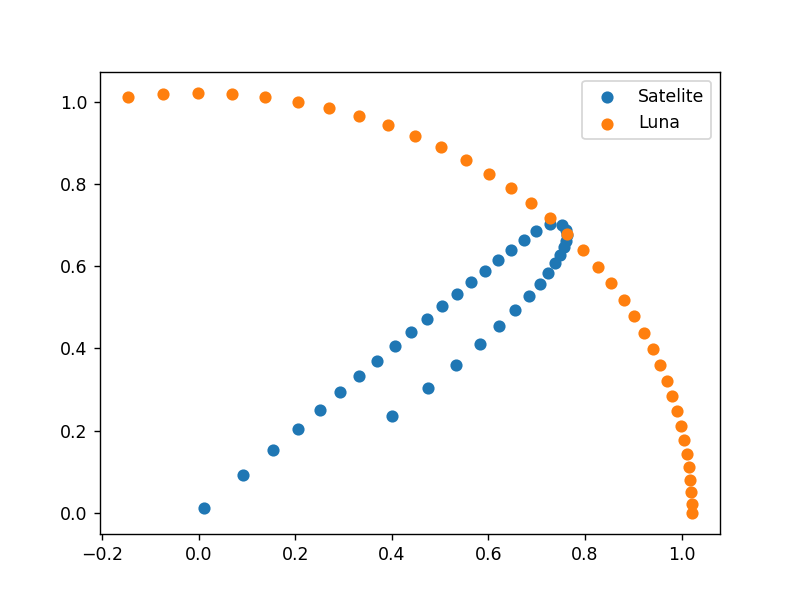

In [12]:
plt.scatter(x,y,label='Satelite')
plt.scatter(xluna,yluna,label='Luna')
plt.legend()
plt.show()

In [13]:
def update(frame):
    plt.clf()  # Clear the previous frame
    plt.plot(x[:frame], y[:frame], label='Satellite')
    plt.plot(xluna[:frame], yluna[:frame], label='Moon')
    plt.scatter(x[frame], y[frame], color='red')  # Highlight the current satellite position
    plt.scatter(xluna[frame], yluna[frame], color='blue')  # Highlight the current moon position
    plt.legend()
    plt.title('Satellite and Moon Motion')
    plt.xlabel('X Position')
    plt.ylabel('Y Position')

<IPython.core.display.Javascript object>


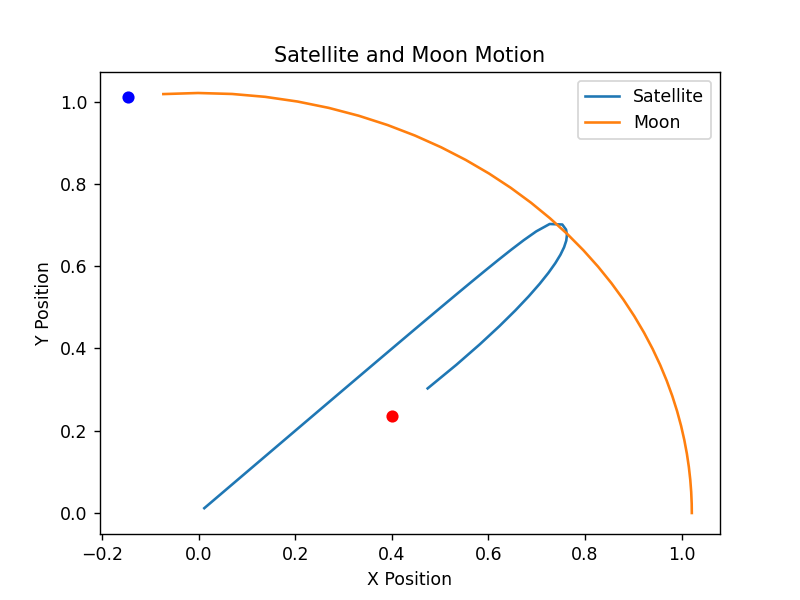

In [14]:
fig, ax = plt.subplots()

# Set up the animation
animation = FuncAnimation(fig, update, frames=len(x), interval=50, repeat=False)

plt.show()